
FINAL MODEL ACCURACY: 34.20%

              precision    recall  f1-score   support

        Cash       0.35      0.37      0.36       671
      Credit       0.32      0.24      0.27       650
 Installment       0.35      0.42      0.38       679

    accuracy                           0.34      2000
   macro avg       0.34      0.34      0.34      2000
weighted avg       0.34      0.34      0.34      2000



C:\Users\chara\AppData\Local\Temp\ipykernel_4128\898680981.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='magma')


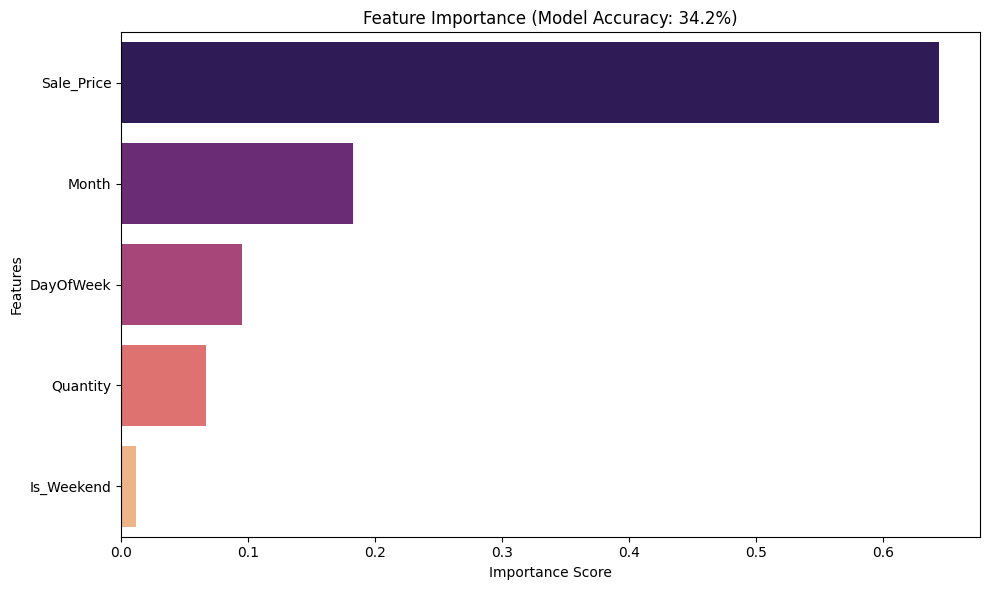


>>> INSIGHT: 
The model relies heavily on 'Sale_Price' (0.64 importance). 
However, given the low accuracy (~34%), this indicates that while 'Sale_Price' 
is the 'best' feature available, it still lacks strong predictive power for Payment Method.


[ANALYSIS 2] Generating Price Distribution Box Plot...


C:\Users\chara\AppData\Local\Temp\ipykernel_4128\898680981.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Payment_Method', y='Sale_Price', data=df, palette='Set2')


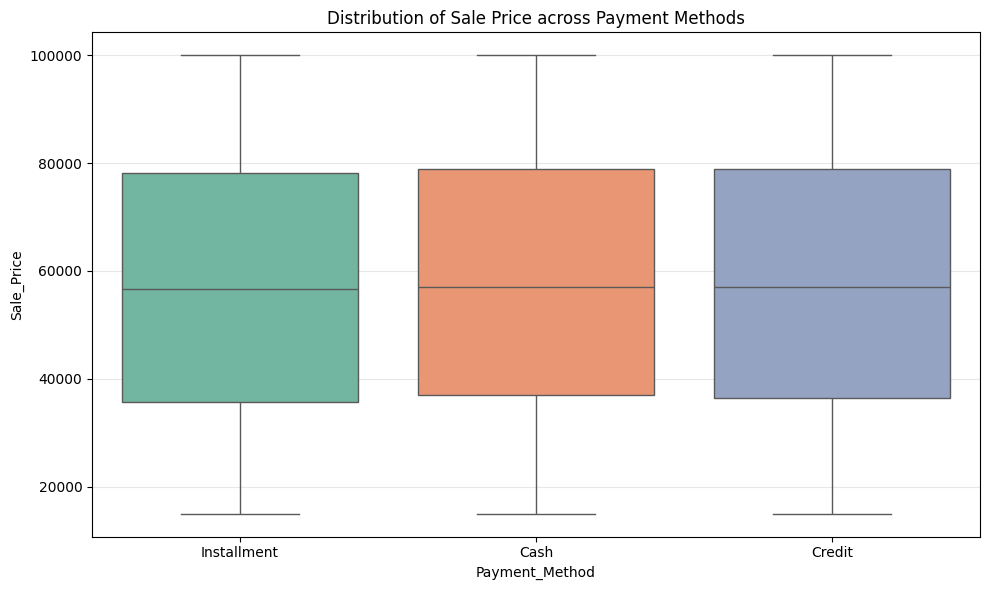


>>> INSIGHT: 
The Box Plot shows identical price distributions for Cash, Credit, and Installment.
This disproves the hypothesis that 'Higher prices lead to Installments'. 
The overlap explains why the model cannot distinguish between payment types based on Price.



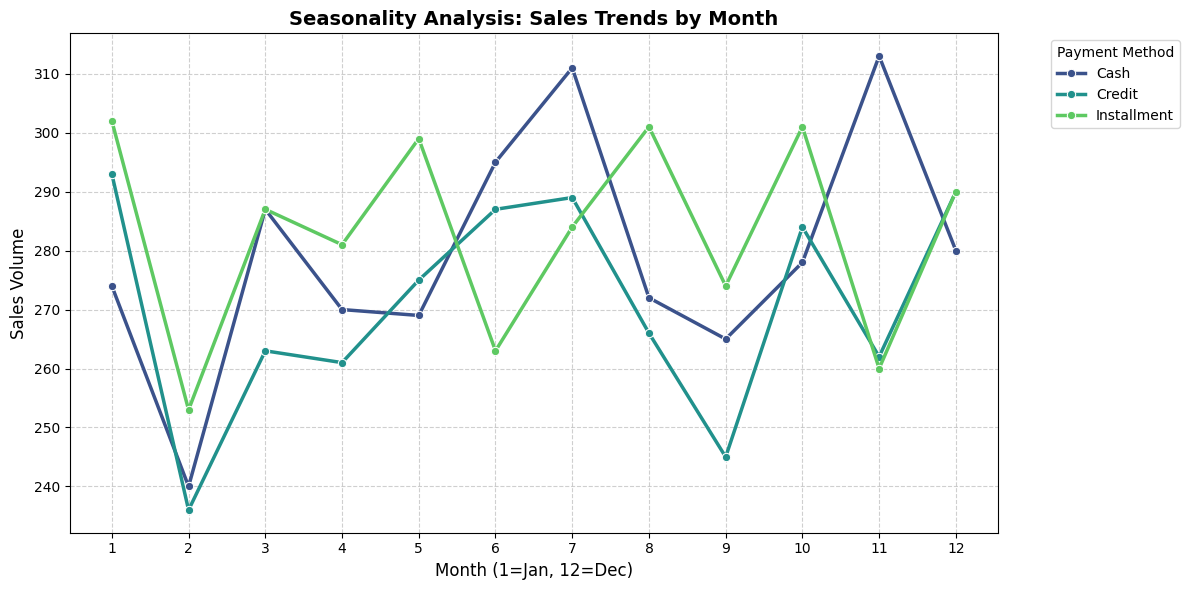


>>> INSIGHT: 
This graph tracks monthly sales volume. While it doesn't improve the prediction accuracy,
it provides business value by highlighting peak sales periods (Seasonality), allowing
the dealership to optimize inventory regardless of individual payment prediction.



In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# ==========================================
# 1. Load Data
# ==========================================
try:
    df = pd.read_csv('Sales.csv')
except FileNotFoundError:
    df = pd.read_csv('../data/Sales.csv')

# ==========================================
# 2. Feature Engineering
# ==========================================
# Convert Dates
df['Sale_Date'] = pd.to_datetime(df['Sale_Date'])

# Create Time Features
df['Month'] = df['Sale_Date'].dt.month
df['DayOfWeek'] = df['Sale_Date'].dt.dayofweek
df['Is_Weekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Drop high-cardinality/noise columns
drop_cols = ['Sale_ID', 'Customer_ID', 'Car_ID', 'Salesperson', 'Sale_Date']
df_clean = df.drop(columns=drop_cols)

# ==========================================
# 3. Encoding & Scaling
# ==========================================
le = LabelEncoder()
df_clean['Payment_Method_Encoded'] = le.fit_transform(df_clean['Payment_Method'])

X = df_clean.drop(columns=['Payment_Method', 'Payment_Method_Encoded'])
y = df_clean['Payment_Method_Encoded']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ==========================================
# 4. Train/Test Split & Training
# ==========================================
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# ==========================================
# 5. Evaluation Output
# ==========================================
accuracy = accuracy_score(y_test, y_pred)
print("\n" + "="*40)
print(f"FINAL MODEL ACCURACY: {accuracy:.2%}")
print("="*40 + "\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# ==========================================
# 6. VISUALIZATION 1: Feature Importance
# ==========================================
# Why: To show that Price/Quantity don't strongly predict Payment Method (justifying low accuracy)
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index, palette='magma')
plt.title(f'Feature Importance (Model Accuracy: {accuracy:.1%})')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('payment_feature_importance.png')
plt.show()

print(f"""
>>> INSIGHT: 
The model relies heavily on '{importances.index[0]}' ({importances.iloc[0]:.2f} importance). 
However, given the low accuracy (~34%), this indicates that while '{importances.index[0]}' 
is the 'best' feature available, it still lacks strong predictive power for Payment Method.
""")

# ==========================================
# 7. VISUALIZATION 2: Price Distribution (Box Plot)
# ==========================================
print("\n[ANALYSIS 2] Generating Price Distribution Box Plot...")
plt.figure(figsize=(10, 6))
sns.boxplot(x='Payment_Method', y='Sale_Price', data=df, palette='Set2')
plt.title('Distribution of Sale Price across Payment Methods')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('price_boxplot.png')
plt.show()

print("""
>>> INSIGHT: 
The Box Plot shows identical price distributions for Cash, Credit, and Installment.
This disproves the hypothesis that 'Higher prices lead to Installments'. 
The overlap explains why the model cannot distinguish between payment types based on Price.
""")

# ==========================================
# 8. VISUALIZATION 3: Seasonality Analysis
# ==========================================
# Why: To provide Business Intelligence despite the model's low predictive power
seasonal_data = df.groupby(['Month', 'Payment_Method']).size().reset_index(name='Count')

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=seasonal_data, 
    x='Month', 
    y='Count', 
    hue='Payment_Method', 
    marker='o', 
    linewidth=2.5,
    palette='viridis'
)
plt.title('Seasonality Analysis: Sales Trends by Month', fontsize=14, fontweight='bold')
plt.xlabel('Month (1=Jan, 12=Dec)', fontsize=12)
plt.ylabel('Sales Volume', fontsize=12)
plt.xticks(range(1, 13))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Payment Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('seasonality_graph.png')
plt.show()
print("""
>>> INSIGHT: 
This graph tracks monthly sales volume. While it doesn't improve the prediction accuracy,
it provides business value by highlighting peak sales periods (Seasonality), allowing
the dealership to optimize inventory regardless of individual payment prediction.
""")